# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2DTranspose

# Import auxiliary libraries
import importlib
import auxlib; importlib.reload(auxlib)

Importing library...
Library successfully imported
Importing library...
Library successfully imported


<module 'auxlib' from 'd:\\Facultad\\Doctorado\\Proyectos\\Uncovering Magnetic Phases\\auxlib\\__init__.py'>

# Main variables

In [2]:
L = 40

training = ['all']

densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

densities_str = ['055','06', '061', '062', '063', '064', '065', '07', '08', '09','1']

first_neurons = [i for i in range(1,11)]
middle_neurons = [20 * i for i in range(1,6)]
last_neurons = [50 * i for i in range(3,21)]

neurons = first_neurons + middle_neurons + last_neurons

seed = 15

# Directory

In [3]:
folder = auxlib.folders(type='dnn', training=training)
folder_figs = auxlib.folders_figs(type='dnn', training=training)

# Synthetic data

In [ ]:
# Initialize the synthetic image generator

data = auxlib.SyntheticImagesGen(training=training, L=L)

# Generate synthetic data

train_images, train_labels = data.dataGenerator(10000)
test_images, test_labels = data.dataGenerator(1000)

train_images = train_images.reshape((10000, L * L))
test_images = test_images.reshape((1000, L * L))

Generating synthetic data...
Done!
Elapsed time: 4.7561681270599365 seconds
Generating synthetic data...
Done!
Elapsed time: 0.03988957405090332 seconds


In [ ]:
# Print the number of samples in each class

l, m, n, o = 0, 0, 0, 0

for i in range(len(list(train_labels))):
	if train_labels[i] == 0:
		l += 1
	elif train_labels[i] == 1:
		m += 1
	elif train_labels[i] == 2:
		n += 1
	elif train_labels[i] == 3:
		o += 1
print("Number of paramagnetic samples: ", l)
print("Number of ferromagnetic samples: ", m)
print("Number of neel samples: ", n)
print("Number of stripe samples: ", o)
print("Total number of samples: ", l + m + n + o)

Number of paramagnetic samples:  1112
Number of ferromagnetic samples:  2222
Number of neel samples:  2222
Number of stripe samples:  4444
Total number of samples:  10000


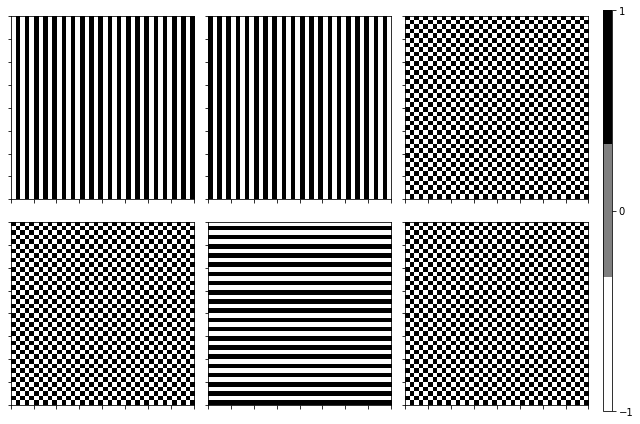

In [ ]:
# Random graphs

lattices_to_graph = [train_images[10 * i].reshape((L, L)) for i in range(6)]

auxlib.latticeGraph(lattices_to_graph, L)

# Training of Neural Network

In [ ]:
# DNN Model
def dnn_model(L, neurons, training=['all'], kernel_regularizer=None, callbacks=None):
	if training == ['all']:
		training = ['para', 'ferro', 'neel', 'stripe']
	dnn = Sequential()

	dnn.add(Dense(neurons, activation='relu',
								kernel_regularizer=kernel_regularizer,
								input_shape=(L*L,)))
	dnn.add(Dropout(0.2))
	dnn.add(Dense(len(training), activation='softmax'))



	dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
	dnn.summary()

	dnn.fit(train_images, train_labels,
			epochs=50, batch_size=20,
			validation_data=(test_images, test_labels),
			callbacks=[callbacks],
			verbose=False)
	return dnn

In [ ]:
# Callback to stop training when accuracy is high enough

class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):

        if(logs.get('val_accuracy') > 0.999):
            print("\nAccuracy is high enough, cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
for neuron in tqdm(neurons, desc=f"Generating DNN models", unit="neuron"):
	np.random.seed(seed)
	if neuron==1 or neuron==2:
		kernel_regularizer=tf.keras.regularizers.l2(0.001)
	else:
		kernel_regularizer=tf.keras.regularizers.l2(0.01)

	dnn = dnn_model(L, neuron, kernel_regularizer=kernel_regularizer, callbacks=callbacks)

	# Saving the model
	dnn.save(os.path.join(folder, f'dnn_{neuron}.h5'))

# Loading simulated images to test the NN

In [4]:
densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

densities_str = ['055','06', '061', '062', '063', '064', '065', '07', '08', '09','1']

In [ ]:
# Initializing loader and saver

loader_init = auxlib.loader_and_saver(os.getcwd())

# Loading simulated images

sim_images, temperature = loader_init.simulatedImages(-1)


Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:01<00:00, 80.61array/s]

Files loaded!
Data of density p = 1. succesfully loaded.


# Predictions

In [ ]:
for neuron in neurons:
	index = neurons.index(neuron)
	sim_images = [array.reshape((251, L*L)) for array in sim_images]
	model_path = os.path.join(folder, f'dnn_{neuron}.h5')

	dnn = keras.models.load_model(model_path)

	prediction = dnn.predict(sim_images[0], verbose=False)/len(sim_images)
	for i in tqdm(range(1, len(sim_images)),
							desc=f"Predicting ({neuron} neurons)", unit="repetitions"):
		sim_im = sim_images[i]
		prediction += dnn.predict(sim_im, verbose=False)/len(sim_images)

	# Saving the predictions
	if training == ['all']:
		columns = ['temperature', 'paramagnetic', 'ferromagnetic', 'neel', 'stripe']
	else:
		columns = ['temperature'] + training

	temperature = np.arange(0.0, 5.02, 0.02).reshape(251,1)
	combined_array = np.concatenate((temperature, prediction), axis=1)
	prediction_df = pd.DataFrame(combined_array, columns=columns)
	prediction_df.to_csv(os.path.join(folder, f'predictions_{neuron}.csv'), index=False)

# Plotting probability for 8 and 1000 neurons

Tc (1000 neurons) = 2.3951360360943865
Tc (8 neurons) = 2.388494075029971


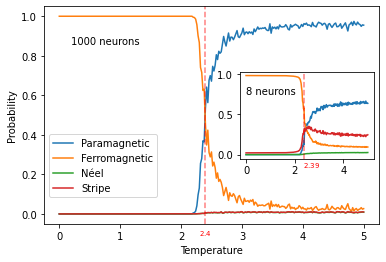

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

prediction = pd.read_csv(folder+f'/predictions_1000.csv', header=0).to_numpy(float)
temperature, para, ferro, neel, stripe = prediction.T

fig, ax = plt.subplots()
ax.plot(temperature, para, label='Paramagnetic')
ax.plot(temperature, ferro, label='Ferromagnetic')
ax.plot(temperature, neel, label='Néel')
ax.plot(temperature, stripe, label='Stripe')
if max(ferro)<0.5:
	tc = 0
else:
	index_half = np.where(ferro > 0.5)[0][-1]
	tc = temperature[index_half] + (ferro[index_half]-0.5)*(temperature[index_half+1] - temperature[index_half]) / (ferro[index_half] - ferro[index_half+1])
	ax.axvline(x=tc,  color = 'red', linestyle = '--', alpha = 0.5)
	ax.text(tc, -0.07, rf'${round(tc,2)}$', color='red',
		verticalalignment='top', horizontalalignment='center', fontsize=7)
print(f'Tc (1000 neurons) = {tc}')

ax.text(0.2, 0.9, '1000 neurons', color='black',
		verticalalignment='top', horizontalalignment='left', fontsize=10)

prediction = pd.read_csv(folder+f'/predictions_8.csv', header=0).to_numpy(float)
temperature, para, ferro, neel, stripe = prediction.T
ax_inset = inset_axes(ax, width="40%", height="40%", loc='center right')

ax_inset.plot(temperature, para, label='Paramagnetic')
ax_inset.plot(temperature, ferro, label='Ferromagnetic')
ax_inset.plot(temperature, neel, label='Néel')
ax_inset.plot(temperature, stripe, label='Stripe')
if max(ferro)<0.5:
	tc = 0
else:
	index_half = np.where(ferro > 0.5)[0][-1]
	tc = temperature[index_half] + (ferro[index_half]-0.5)*(temperature[index_half+1] - temperature[index_half]) / (ferro[index_half] - ferro[index_half+1])
	ax_inset.axvline(x=tc,  color = 'red', linestyle = '--', alpha = 0.5)
	ax.text(4., 0.27, rf'${round(tc,2)}$', color='red',
	verticalalignment='top', horizontalalignment='left', fontsize=7)

ax_inset.text(0.0, 0.85, '8 neurons', color='black',
		verticalalignment='top', horizontalalignment='left', fontsize=10)


ax.set_xlabel('Temperature')
ax.set_ylabel('Probability')
ax.legend(loc = 'lower left', bbox_to_anchor=(0., 0.1))
print(f'Tc (8 neurons) = {tc}')
plt.savefig(os.path.join(folder_figs, f'neurons_8_and_1000.pdf'))
plt.show()

# Calculating critical temperature

Prediction for 1 neurons in hidden layer
T_c = 0


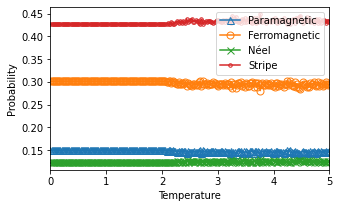

Prediction for 2 neurons in hidden layer
T_c = 2.103120932366888


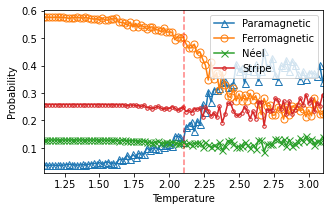

Prediction for 3 neurons in hidden layer
T_c = 0


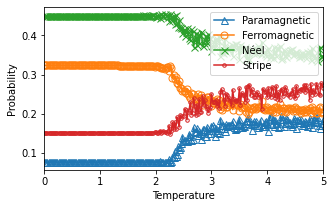

Prediction for 4 neurons in hidden layer
T_c = 2.3084087614867776


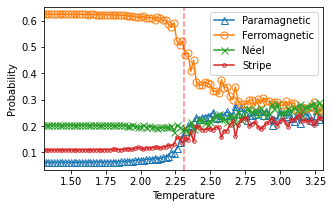

Prediction for 5 neurons in hidden layer
T_c = 2.761537504783773


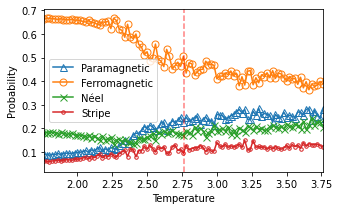

Prediction for 6 neurons in hidden layer
T_c = 2.45016213048044


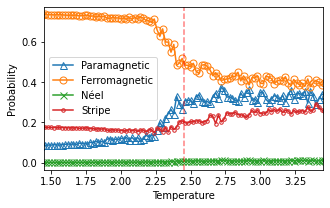

Prediction for 7 neurons in hidden layer
T_c = 2.330277232760814


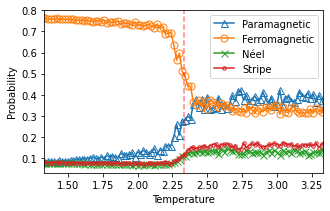

Prediction for 8 neurons in hidden layer
T_c = 2.388494075029971


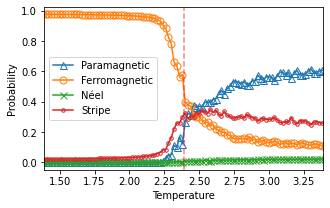

Prediction for 9 neurons in hidden layer
T_c = 2.8611754855782907


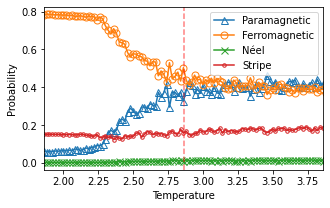

Prediction for 10 neurons in hidden layer
T_c = 2.398461840230744


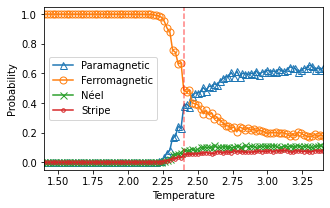

Prediction for 20 neurons in hidden layer
T_c = 2.5025795010784604


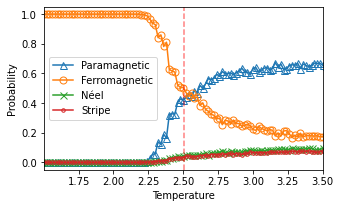

Prediction for 40 neurons in hidden layer
T_c = 2.3911837857700817


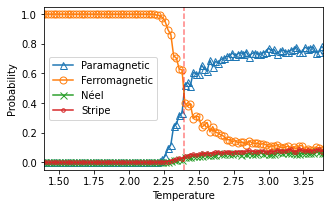

Prediction for 60 neurons in hidden layer
T_c = 2.3945793370931203


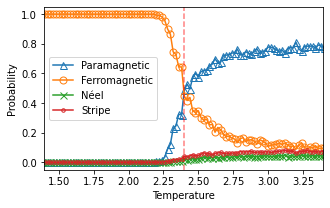

Prediction for 80 neurons in hidden layer
T_c = 2.41667534066426


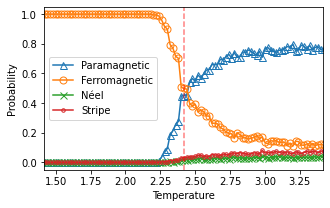

Prediction for 100 neurons in hidden layer
T_c = 2.3951419756265175


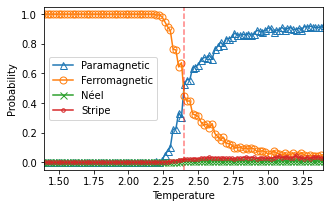

Prediction for 150 neurons in hidden layer
T_c = 2.381994275395109


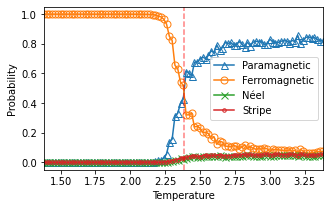

Prediction for 200 neurons in hidden layer
T_c = 2.319801477356385


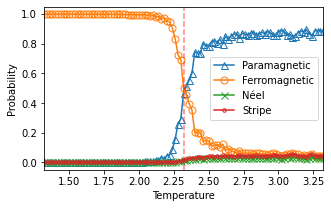

Prediction for 250 neurons in hidden layer
T_c = 2.3455787405399264


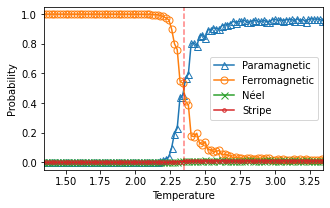

Prediction for 300 neurons in hidden layer
T_c = 2.3107460638647743


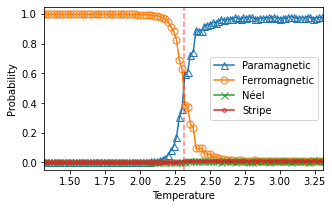

Prediction for 350 neurons in hidden layer
T_c = 2.30801188275943


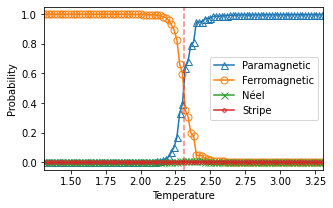

Prediction for 400 neurons in hidden layer
T_c = 2.3502470088843315


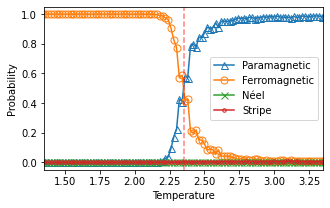

Prediction for 450 neurons in hidden layer
T_c = 2.3118072392792923


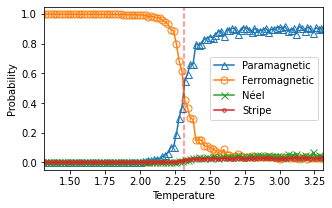

Prediction for 500 neurons in hidden layer
T_c = 2.4214116605782827


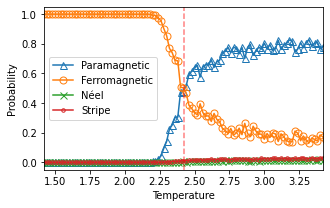

Prediction for 550 neurons in hidden layer
T_c = 2.3117229175628786


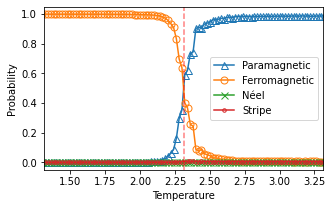

Prediction for 600 neurons in hidden layer
T_c = 2.316387386670558


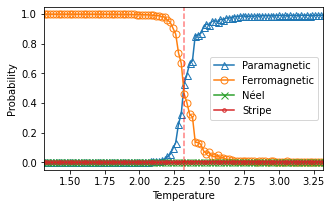

Prediction for 650 neurons in hidden layer
T_c = 2.307766060733449


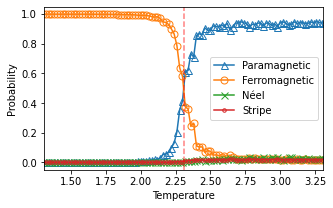

Prediction for 700 neurons in hidden layer
T_c = 2.3117022652600667


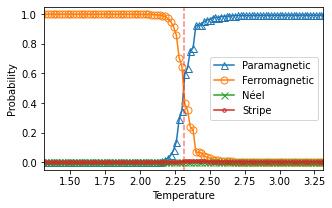

Prediction for 750 neurons in hidden layer
T_c = 2.6924636902578833


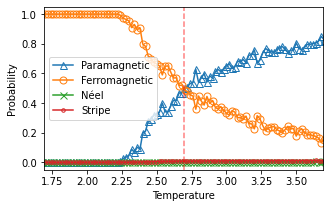

Prediction for 800 neurons in hidden layer
T_c = 2.3230445934859736


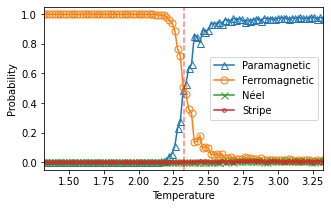

Prediction for 850 neurons in hidden layer
T_c = 2.301598423234986


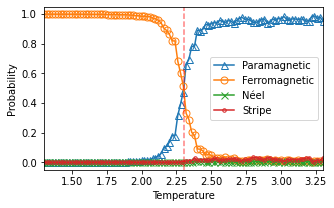

Prediction for 900 neurons in hidden layer
T_c = 2.3117514010772275


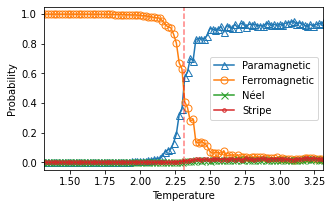

Prediction for 950 neurons in hidden layer
T_c = 2.3371487537363103


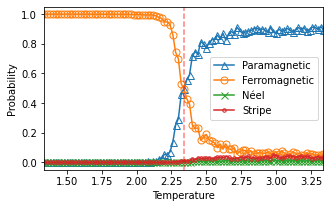

Prediction for 1000 neurons in hidden layer
T_c = 2.3951360360943865


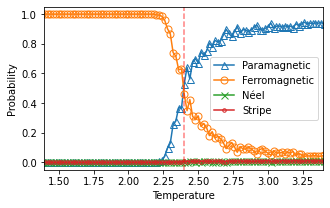

In [ ]:
critical_temperatures = []

for neuron in neurons:
	prediction = pd.read_csv(folder+f'/predictions_{neuron}.csv', header=0).to_numpy(float)
	temperature, para, ferro, neel, stripe = prediction.T

	print(f'Prediction for {neuron} neurons in hidden layer')

	plt.figure(figsize=(5, 3))
	plt.plot(temperature, para, '^-', label='Paramagnetic', markerfacecolor='none', markersize=7)
	plt.plot(temperature, ferro, 'o-', label='Ferromagnetic', markerfacecolor='none', markersize=7)
	plt.plot(temperature, neel, 'x-', label='Néel', markerfacecolor='none', markersize=7)
	plt.plot(temperature, stripe, '.-', label='Stripe', markerfacecolor='none', markersize=7)

	if max(ferro)<0.5:
		tc = 0
	else:
		index_half = np.where(ferro > 0.5)[0][-1]
		tc = temperature[index_half] + (ferro[index_half]-0.5)*(temperature[index_half+1] - temperature[index_half]) / (ferro[index_half] - ferro[index_half+1])
		plt.axvline(x=tc,  color = 'red', linestyle = '--', alpha = 0.5)

	critical_temperatures.append(tc)
	print(f'T_c = {tc}')
	
	if tc==0:
		plt.xlim((0, 5))
	else:
		plt.xlim((tc-1, tc+1))

	plt.xlabel('Temperature')
	plt.ylabel('Probability')
	plt.legend()

	plt.savefig(os.path.join(folder_figs, f'plot_{neuron}_neurons.pdf'))
	plt.show()

In [ ]:
temp = pd.DataFrame((np.concatenate((np.array(neurons).reshape(len(neurons),1),
                                    np.array(critical_temperatures).reshape(len(neurons),1)),axis=1)),
                                    columns=['Neurons','Temperature'])
temp.to_csv(os.path.join(folder, 'critical_temperatures.csv'), index=False)

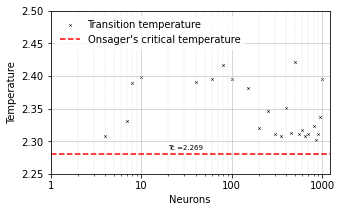

In [ ]:
import matplotlib.ticker as ticker

temp = pd.read_csv(os.path.join(folder, f'critical_temperatures.csv'))

plt.figure(figsize=(5, 3))
plt.scatter(temp['Neurons'][2:],temp['Temperature'][2:], marker='x', s=7, linewidth=0.5 ,color='black', label='Transition temperature')
for i in (1, 2, 3, 4, 5, 20):
	neuron = i
	#plt.annotate(f'n = {int(temp["Neurons"][neuron])}', xy=(temp['Neurons'][neuron],temp['Temperature'][neuron]),
	#			xytext=(temp['Neurons'][neuron],temp['Temperature'][neuron]+0.015), textcoords='data',
	#			ha='right', va='bottom',
	#			fontsize=14,
	#			bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.2))

plt.axhline(y=2.28, color = 'red', linestyle = '--', label = "Onsager's critical temperature")
plt.xscale('log')
plt.xlabel('Neurons')
plt.ylabel('Temperature')



plt.text(20, 2.295, rf'Tc ={2.269}', color='black', bbox=dict(boxstyle='round', fc='white', ec='none'),
        verticalalignment='top', horizontalalignment='left', fontsize=7)

plt.ylim((2.25, 2.5))
plt.xlim((1, 1200))
plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1]))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}'))
plt.grid(which='major', axis='both', linestyle='-', linewidth=0.5)
plt.grid(which='minor', axis='x', linestyle='--', linewidth=0.2)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon = True, edgecolor='white', facecolor='white')
plt.savefig(os.path.join(folder_figs, 'critical_temperatures.pdf'))
plt.show()

# Graphing the predictions of each feature and different number of neurons

Feature: para


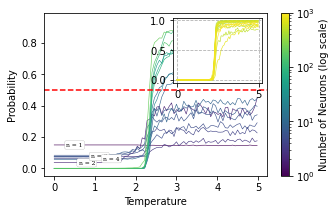

Feature: ferro


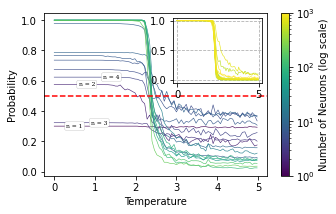

Feature: neel


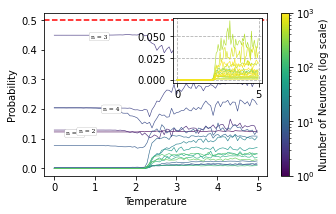

Feature: stripe


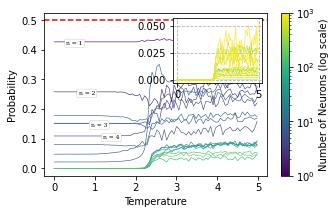

In [ ]:
from matplotlib.colors import LogNorm
features = ['para', 'ferro', 'neel', 'stripe']

first_neurons = [i for i in range(1, 11)]
middle_neurons = [20 * i for i in range(1, 6)]
last_neurons = [50 * i for i in range(3, 21)]

neurons = first_neurons + middle_neurons + last_neurons

cmap = plt.get_cmap('viridis')  # ('coolwarm')

# Use LogNorm for logarithmic scaling of the color mapping
norm = LogNorm(vmin=1, vmax=1000)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


for feature in features:
    print(f'Feature: {feature}')
    fig, ax = plt.subplots(figsize=(5, 3))
    ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper right')  # Inset

    index = features.index(feature) + 1

    # Main plot: n <= 200
    for neuron in neurons:
        data_np = pd.read_csv(os.path.join(folder, f'predictions_{neuron}.csv'), header=0).to_numpy(float)
        temperature, para, ferro, neel, stripe = data_np.T
        data = [temperature, para, ferro, neel, stripe]
        alternating_indices = np.arange(0, len(data[0]), 3)

        # Plot n <= 200 in the main axis
        if neuron <= 200:
            ax.plot(data[0][alternating_indices], data[index][alternating_indices],'-', linewidth=0.6, color=cmap(norm(neuron)))
            if neuron in (1, 2, 3, 4):
                ax.annotate(f'n = {neuron}', xy=(1.0, data[index][50]),
                            xytext=(0.3*(neuron), data[index][50]-0.01), textcoords='data',
                            font = 'serif', fontsize=6,
                            bbox=dict(boxstyle='round', fc='white', ec='black', linewidth=0.1, pad=0.3))
        # Plot n > 200 in the inset axis
        else:
            ax_inset.plot(data[0][alternating_indices], data[index][alternating_indices],'-', linewidth=0.6, color=cmap(norm(neuron)))
            ax_inset.grid(linestyle='--')

    # Main plot settings
    ax.axhline(y=0.5, color='r', linestyle='--')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Probability')

    # Add the colorbar with logarithmic scaling to the main plot
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Number of Neurons (log scale)')

    # Save the figure
    plt.savefig(os.path.join(folder_figs, f'all_neurons_{feature}_1-1000.pdf'))
    plt.show()


# Percolation

In [7]:
loader_init = auxlib.loader_and_saver(os.getcwd())

In [8]:
L = 40

training = ['all']

densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

densities_str = ['055','06', '061', '062', '063', '064', '065', '07', '08', '09','1']

neurons = 200

seed = 15

In [ ]:
for density_index, density in enumerate(densities):
	
	sim_images, temperature = loader_init.simulatedImages(density_index)
	sim_images = [array.reshape((251, L*L)) for array in sim_images]

	model_path = os.path.join(folder, f'dnn_{neurons}.h5')

	dnn = keras.models.load_model(model_path)
	
	prediction = dnn.predict(sim_images[0], verbose=False)/len(sim_images)
	for i in tqdm(range(1, len(sim_images)),
							desc=f"Predicting (rho = {density})", unit="repetitions"):
		sim_im = sim_images[i]
		prediction += dnn.predict(sim_im, verbose=False)/len(sim_images)

	# Saving the predictions
	if training == ['all']:
		columns = ['temperature', 'paramagnetic', 'ferromagnetic', 'neel', 'stripe']
	else:
		columns = ['temperature'] + training

	temperature = np.arange(0.0, 5.02, 0.02).reshape(251,1)
	combined_array = np.concatenate((temperature, prediction), axis=1)
	prediction_df = pd.DataFrame(combined_array, columns=columns)
	prediction_df.to_csv(os.path.join(folder, f'perco_predictions_p{density}.csv'), index=False)


Loading simulated images...


Loading arrays: 100%|██████████| 196/196 [00:05<00:00, 34.43array/s]


Files loaded!
Data of density p = 0.55 succesfully loaded.


Predicting ($\rho = $0.55): 100%|██████████| 195/195 [00:24<00:00,  7.88repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 150/150 [00:02<00:00, 54.07array/s]


Files loaded!
Data of density p = 0.6 succesfully loaded.


Predicting ($\rho = $0.6): 100%|██████████| 149/149 [00:15<00:00,  9.90repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 199/199 [00:02<00:00, 66.75array/s]


Files loaded!
Data of density p = 0.61 succesfully loaded.


Predicting ($\rho = $0.61): 100%|██████████| 198/198 [00:22<00:00,  8.91repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 187/187 [00:03<00:00, 57.62array/s]


Files loaded!
Data of density p = 0.62 succesfully loaded.


Predicting ($\rho = $0.62): 100%|██████████| 186/186 [00:22<00:00,  8.33repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 163/163 [00:03<00:00, 52.31array/s]


Files loaded!
Data of density p = 0.63 succesfully loaded.


Predicting ($\rho = $0.63): 100%|██████████| 162/162 [00:18<00:00,  8.90repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 142/142 [00:03<00:00, 37.06array/s]


Files loaded!
Data of density p = 0.64 succesfully loaded.


Predicting ($\rho = $0.64): 100%|██████████| 141/141 [00:20<00:00,  6.98repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 161/161 [00:05<00:00, 28.88array/s]


Files loaded!
Data of density p = 0.65 succesfully loaded.


Predicting ($\rho = $0.65): 100%|██████████| 160/160 [00:48<00:00,  3.32repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 151/151 [00:03<00:00, 45.13array/s]


Files loaded!
Data of density p = 0.7 succesfully loaded.


Predicting ($\rho = $0.7): 100%|██████████| 150/150 [00:28<00:00,  5.34repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 155/155 [00:04<00:00, 38.10array/s]


Files loaded!
Data of density p = 0.8 succesfully loaded.


Predicting ($\rho = $0.8): 100%|██████████| 154/154 [00:25<00:00,  6.01repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 139/139 [00:04<00:00, 32.72array/s]


Files loaded!
Data of density p = 0.9 succesfully loaded.


Predicting ($\rho = $0.9): 100%|██████████| 138/138 [00:14<00:00,  9.27repetitions/s]


Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:02<00:00, 70.22array/s]


Files loaded!
Data of density p = 1. succesfully loaded.


Predicting ($\rho = $1.0): 100%|██████████| 155/155 [00:21<00:00,  7.37repetitions/s]


## Critical temperature (Percolation)

Prediction for rho = 0.55
T_c = 0
Prediction for rho = 0.6
T_c = 0
Prediction for rho = 0.61
T_c = 0
Prediction for rho = 0.62
T_c = 0.4881177529719773
Prediction for rho = 0.63
T_c = 0.7379666167025006
Prediction for rho = 0.64
T_c = 0.818716809480958
Prediction for rho = 0.65
T_c = 0.874056130222794
Prediction for rho = 0.7
T_c = 1.1491171628042591
Prediction for rho = 0.8
T_c = 1.592885623545763
Prediction for rho = 0.9
T_c = 1.9615221371374738
Prediction for rho = 1.0
T_c = 2.319801477356385


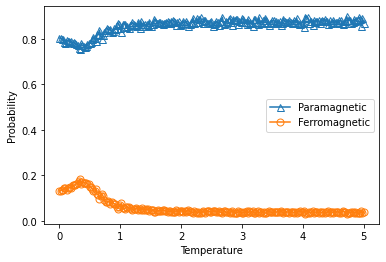

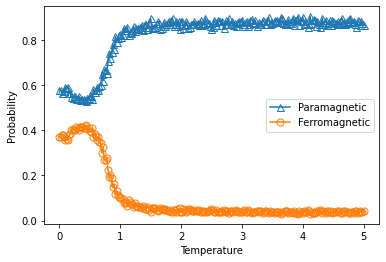

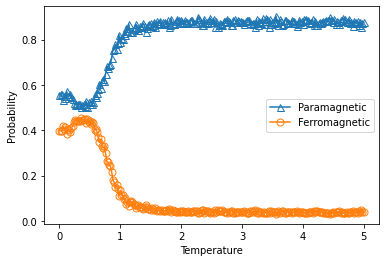

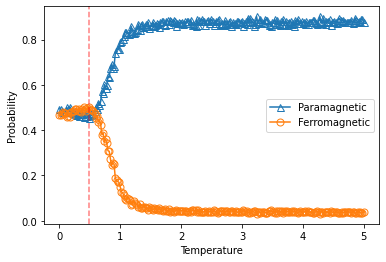

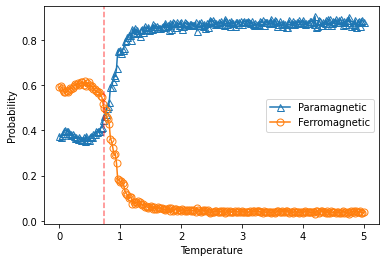

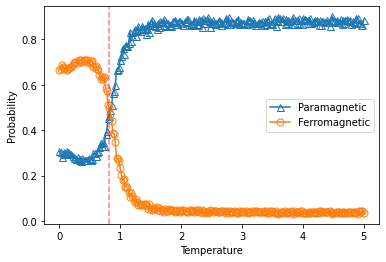

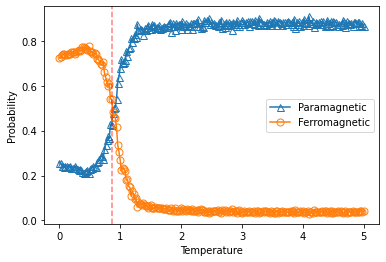

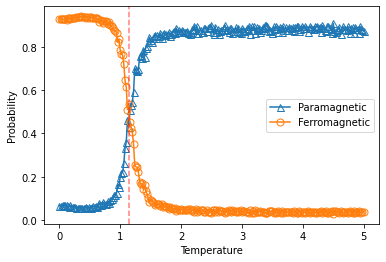

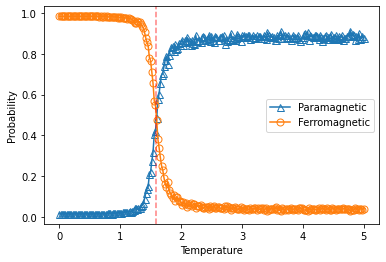

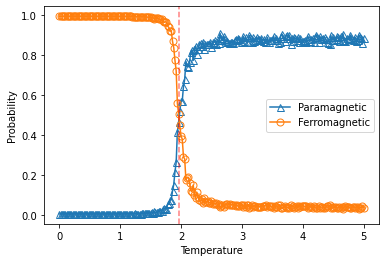

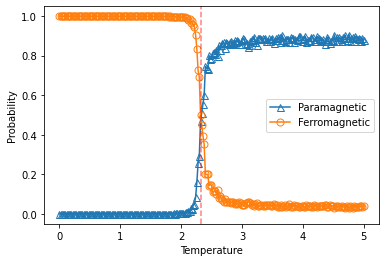

In [11]:
critical_temperatures = []

for density_index, density in enumerate(densities):
	prediction = pd.read_csv(os.path.join(folder, f'perco_predictions_p{density}.csv'), header=0).to_numpy(float)
	if training == ['all']:
		temperature, para, ferro, neel, stripe = prediction.T
	elif training == ['para', 'ferro']:
		temperature, para, ferro = prediction.T

	print(f'Prediction for rho = {density}')

	plt.figure()
	plt.plot(temperature, para, '^-', label='Paramagnetic', markerfacecolor='none', markersize=7)
	plt.plot(temperature, ferro, 'o-', label='Ferromagnetic', markerfacecolor='none', markersize=7)
	plt.xlabel('Temperature')
	plt.ylabel('Probability')
	plt.legend()

	if max(ferro)<0.5:
		tc = 0
	else:
		index_half = np.where(ferro > 0.5)[0][-1]
		if index_half == 250:
			index_half = 249
		# Interpolation:
		tc = temperature[index_half] + (ferro[index_half]-0.5)*(temperature[index_half+1] - temperature[index_half]) / (ferro[index_half] - ferro[index_half+1])
		plt.axvline(x=tc,  color = 'red', linestyle = '--', alpha = 0.5)

	critical_temperatures.append(tc)
	print(f'T_c = {tc}')
	plt.savefig(os.path.join(folder_figs, f'critical_temperature_{density}.pdf'))
plt.show()

In [12]:
temp = pd.DataFrame((np.concatenate((np.array(densities).reshape(len(densities),1), 
                                    np.array(critical_temperatures).reshape(len(densities),1)),axis=1)), 
                                    columns=['Density','Temperature'])
temp.to_csv(os.path.join(folder, 'critical_temperatures_vs_density.csv'), index=False)

In [ ]:
from scipy.optimize import curve_fit

def model_function(x, A, B, K):
	return - K/np.log(x-B) + A

initial_guesses = [0.0, 0.592746, 1.0]

popt, pcov = curve_fit(model_function, densities[1:], dnn_pred[1:] / np.max(dnn_pred), p0=initial_guesses)

print(popt)
print(pcov)

print(np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]))

sim_density = np.arange(0.6,1.002,0.002)

# Fitting parameters of theoretical curve
x_curve = np.arange(0.0,0.602,0.002)
y_curve = x_curve*0
y_curve[-1] = model_function(sim_density[1], *popt)


def func(x):
  funcion = x.copy()
  for i in range(len(x)):
    if x[i] < 0.6:
      funcion[i]=0
    else:
      funcion[i]=0.32
  return funcion

plt.figure(figsize=(8, 6))

x_int= np.linspace(0.55, 0.6, 200)

plt.plot(sim_density, model_function(sim_density, *popt),'r', label = 'Fitted curve')
plt.plot(x_int, func(x_int), '--', color='r')
plt.scatter(densities, cae_pred_1/np.max(cae_pred_1), marker = 'o', s=30, label='CAE ($m>0$)', color='k', facecolors='none')
plt.scatter(densities, cae_pred_2 / np.max(cae_pred_2), marker = '^', s=30, label='CAE ($m<0$)', color='blue', facecolors='none')
plt.scatter(densities, dnn_pred / np.max(dnn_pred), marker = 'x', s=30, label='DNN', color='green')
plt.xlabel(r'Density ($\rho$)')
plt.ylabel('Normalized Critical Temperature')
plt.xlim(0.53, 1.01)
plt.grid(alpha=0.5)
plt.legend()

plt.savefig(os.path.join('images', f'cae_dnn_percolation.pdf'))
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\AppData\Local\Temp/ipykernel_13508/472511008.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(model_function, temp['Density'][1:], temp['Temperature'][1:]/tc_rho1, p0=initial_guesses)


[nan nan nan]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


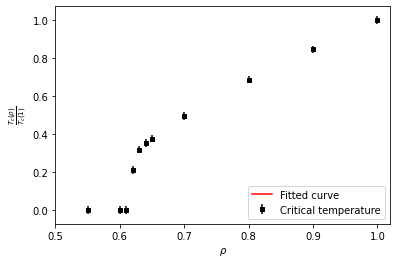

In [14]:
from scipy.optimize import curve_fit

def model_function(x, A, B, K):
	return - K/np.log(x-B) + A

sim_density = np.arange(0.6,1.002,0.002)
temp = pd.read_csv(os.path.join(folder, f'critical_temperatures_vs_density.csv'))

initial_guesses = [0.0, 0.592746, 1.0]

tc_rho1 = temp['Temperature'].to_numpy(float)[-1]
#tc_rho1 = 2.269

popt, pcov = curve_fit(model_function, temp['Density'][1:], temp['Temperature'][1:]/tc_rho1, p0=initial_guesses)

print(popt)
print(pcov)

# Fitting parameters of theoretical curve
x_curve = np.arange(0.0,0.602,0.002)
y_curve = x_curve*0
y_curve[-1] = model_function(sim_density[1], *popt)





plt.figure()
plt.errorbar(temp['Density'],temp['Temperature']/tc_rho1,
			color='black',
			yerr=0.02,
			fmt='s',
			markersize=4,
			label='Critical temperature')#np.array(temp_df['Temperatura'])[-1],'x--')
plt.plot(sim_density, model_function(sim_density, *popt),'r', label = 'Fitted curve')
#plt.plot(x_curve, y_curve,'-','r')

plt.xlabel(r'$\rho$')
plt.ylabel(r'$\frac{T_c(\rho)}{T_c(1)}$')

#plt.text(800, 2.25, rf'Tc ={2.269}', color='black', 
#        verticalalignment='top', horizontalalignment='left', fontsize=20)

plt.legend(loc='lower right')
plt.xlim(0.5,1.02)
plt.savefig(os.path.join(os.getcwd(), folder_figs, 'critical_temperatures_vs_density(fit).pdf'))
plt.show()

In [ ]:
fig, ax = plt.subplots()

for density_index, density in enumerate(densities):
    prediction = pd.read_csv(resultsfolder+f'/predictions_{densities_str[density_index]}.csv', header=0).to_numpy(float)
    temperature, para, ferro = prediction.T

    ax.plot(temperature, ferro, 'x-', label=rf'$\rho = {density}$', 
            color= plt.cm.viridis_r(density_index/len(densities)), markerfacecolor='none', markersize=7)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Probability')
    ax.legend()
ax.axhline(y = 0.5,  color = 'red', linestyle = '--', alpha = 0.5)
ax.set_xlim(0, 4)
plt.savefig(os.path.join(saving_folder, f'ferro_predictions.pdf'))
plt.show()